<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/Lec_3/Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from google.colab import files
import io, requests, zipfile



'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 5 )
plt.rc('lines', linewidth = 5 )

plt.rc('lines', markersize = 5 )

plt.rc('figure', figsize=(8,4) )         # Image size




import warnings
warnings.filterwarnings('ignore')


from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures , StandardScaler
from sklearn.metrics import mean_squared_error  ## To calculate the loss

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import learning_curve, validation_curve

Bias and Variance Trade-off
==
Often, we our first toy model or estimator does not return a good accuracy and we need to play around and figure out what we need to change. The first two natural questions are 

- Is the model that we are trying good enough to capture the behviour of our data?
- Do we have enough data

Here we describe a procedure that helps us find the answers to these questions and systematically choose the right model and find a good set of hyper-parameters for our model.

The main tools we need for this part come from statistical learning. Namely we will go through the concept of Bias and Variance and the trade-off between them. We then use ''learning curve' and 'validation curve' to get a sense of how much data we need and how complex we should make our model. 

We will introduce some more tools later. 

In [0]:
bbr_data_url = "https://github.com/sraeisi/MachineLearning_Physics/blob/master/Lec_1/bbr.xls?raw=true"

bbr_data = pd.read_excel(bbr_data_url)

# bbr_data = pd.read_excel('bbr.xls')

data = bbr_data[[0,'T']]

data.head()

,0,T
0,88182000000,2.978514e-23
1,176364000000,1.183007e-22
2,264546000000,2.642956e-22
3,352728000000,4.665309e-22
4,440910000000,7.237795e-22


In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures , StandardScaler
from sklearn.metrics import mean_squared_error  ## To calculate the loss


from sklearn.model_selection import learning_curve, validation_curve

In [0]:
%%time
poly_scores = []


polytransform = PolynomialFeatures(degree=2 )
bbr_reg_poly = LinearRegression(n_jobs=-1)
bbr_reg_poly = Ridge()


n_tot = int(len(data) )    ## Total number of samples
n_points = 25              ## Number of points for the learning curve plot
ns_list = np.arange(int(n_tot/n_points)-1,n_tot , int(n_tot/n_points) )      ## x-axis on the learning curve
n_avg = 200                ## Number of times to average

for ns in ns_list:        ## For different subset-sizes we try training our estimator
  e_in = 0
  e_out = 0               ## For each, we record the in and out score. 
  for i in range(n_avg):
    
    sample_data = data.sample(ns)
    X_train, X_test, Y_train, Y_test = train_test_split(sample_data[0].values.reshape(-1,1), sample_data['T'], random_state = 0)

    bbr_reg_poly.fit(       polytransform.fit_transform( X_train )      , Y_train )

    e_in  += mean_squared_error( Y_train, bbr_reg_poly.predict(polytransform.fit_transform( X_train ) ) )
    e_out += mean_squared_error( Y_test , bbr_reg_poly.predict(polytransform.fit_transform( X_test ) )  )
  
  poly_scores += [[e_in/n_avg, e_out/n_avg]]

  
poly_scores = np.array(poly_scores)  

CPU times: user 11.6 s, sys: 9.17 ms, total: 11.6 s
Wall time: 11.6 s


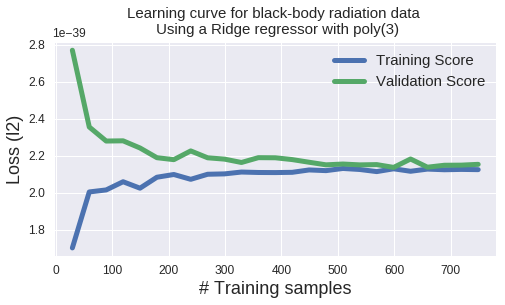

In [0]:
xlabel = '# Training samples'
ylabel = 'Loss (l2)'
plt_title = 'Learning curve for black-body radiation data \n Using a Ridge regressor with poly(3)'
fig = plt.figure()
ax2 = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax2.plot(ns_list, poly_scores[:,0], label = 'Training Score')
ax2.plot(ns_list, poly_scores[:,1], label = 'Validation Score')
ax2.legend(loc=0)


plt.show()

In [0]:
%%time
svr_scores = []

X = data[0].values.reshape(-1,1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
Y = data['T'].values/data['T'].mean()

opt_svr_param = {'C': 0.04, 'degree': 2, 'epsilon': 0.0015, 'gamma': 11}
svr = SVR(**opt_svr_param)

svr = SVR(kernel='poly', degree=2, gamma=11,epsilon=.0015, C=.04 )

n_tot = int(len(data) )
n_points = 10
ns_list = np.arange(int(n_tot/n_points)-1,n_tot , int(n_tot/n_points) )
n_avg = 200

for ns in ns_list:
  e_in = 0
  e_out = 0
  for i in range(n_avg):
    
    sample_data = data.sample(ns)
    ## We'll come back to why we do the following scaling. 
    X = sample_data[0].values.reshape(-1,1)
    X = scaler.transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split( X , sample_data['T']/sample_data['T'].mean(), random_state = 0)

    
    svr.fit(X_train,Y_train)
    e_in  += mean_squared_error(  Y_train, svr.predict(X_train )  )
    e_out += mean_squared_error(  Y_test,  svr.predict(X_test  )  )
  
  svr_scores += [[e_in/n_avg, e_out/n_avg]]

svr_scores = np.array(svr_scores)  

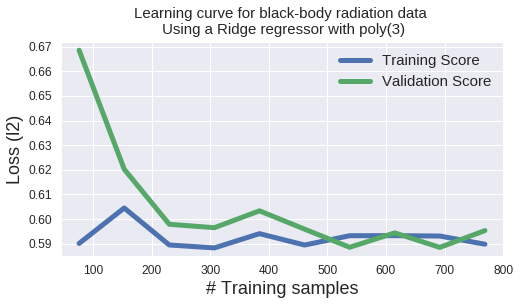

In [0]:
fig = plt.figure()
ax2 = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax2.plot(ns_list, svr_scores[:,0], label = 'Training Score')
ax2.plot(ns_list, svr_scores[:,1], label = 'Validation Score')
ax2.legend(loc=0)
plt.show()

In [0]:
ns_list=np.array([ 10, 20 , 30 , 50, 76, 153, 230, 307, 384, 461, 538, 615])

## How to do this in sklearn

In [0]:
from sklearn.model_selection import learning_curve, validation_curve

In [0]:
X = data[0].values.reshape(-1,1)
# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)

Y = data['T'].values/data['T'].mean()

train_sizes = [1, 100, 200, 300, 400, 500, 600]

ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator = SVR(**opt_svr_param), X = X,
                                                   y = Y, train_sizes = ns_list, cv = 5,
                                                   scoring = 'neg_mean_squared_error')

In [0]:
print('Training scores:\n\n', pd.DataFrame( train_scores) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(validation_scores) )

Training scores:

            0         1         2         3         4
0  -0.000002 -0.000002 -0.000002 -0.000002 -0.000002
1  -0.000041 -0.000118 -0.000118 -0.000118 -0.000118
2  -0.000221 -0.002201 -0.002201 -0.002201 -0.002201
3  -0.000604 -0.022469 -0.022469 -0.022469 -0.022469
4  -0.000460 -0.095065 -0.095065 -0.095065 -0.095065
5  -0.023480 -0.482676 -0.482676 -0.482676 -0.482676
6  -0.140472 -0.393454 -0.726687 -0.726687 -0.726687
7  -0.296745 -0.293314 -0.675227 -0.675227 -0.675227
8  -0.444366 -0.295237 -0.761497 -0.483646 -0.483646
9  -0.566917 -0.328073 -0.710387 -0.444647 -0.444647
10 -0.666946 -0.362873 -0.952329 -0.592358 -0.485314
11 -0.746845 -0.391194 -0.976706 -0.673948 -0.550752

 ----------------------------------------------------------------------

Validation scores:

            0         1         2         3         4
0  -1.903227 -4.901943 -1.515560 -0.161485 -0.008680
1  -1.974794 -4.784359 -1.452690 -0.142084 -0.004907
2  -2.037421 -4.634879 -1.373752 -0.11

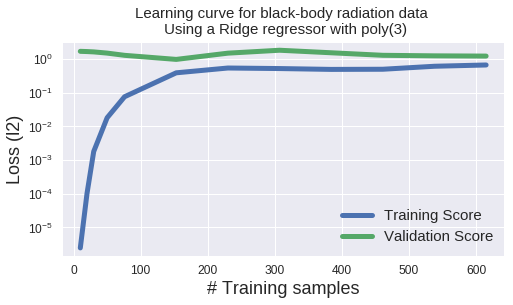

In [0]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(ns_list, train_scores_mean, label = 'Training Score')
ax.plot(ns_list, validation_scores_mean, label = 'Validation Score')
ax.legend(loc=0)
plt.yscale('log')

plt.show()

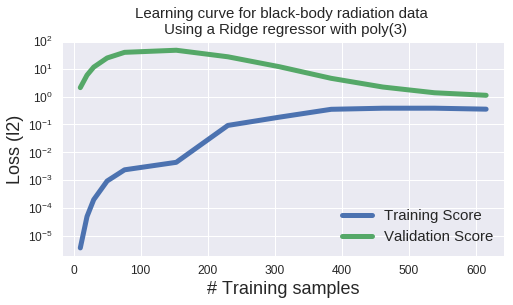

In [0]:
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator = Ridge(), X = X,
                                                   y = Y, train_sizes = ns_list, cv = 5,
                                                   scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(ns_list, train_scores_mean, label = 'Training Score')
ax.plot(ns_list, validation_scores_mean, label = 'Validation Score')
plt.yscale('log')
ax.legend(loc=0)
plt.show()

## Classification

In [2]:
#https://drive.google.com/file/d/17UKL0GGf9VljROIaG3UMa6lVl3rWYAtc/view

url = 'https://www.dropbox.com/s/66dbhxl93y41coe/particle-identification-from-detector-responses.zip?dl=1'
s=requests.get(url, stream=True).content
data=pd.read_csv(io.BytesIO(s) , compression='zip' )
 
'''
Alternatively, you can download the file into your computer and run the following code. 
You need to uncomment it first. 
'''    
# data = pd.read_csv('roboBohr.csv.zip', compression='zip', index_col=0)

targets = list(set(data['id']))
data['target'] = data['id'].apply(lambda x: targets.index(x)) 
data.drop('id',axis=1, inplace=True)

data.head()

,p,theta,beta,nphe,ein,eout,target
0,0.780041,1.081480,0.989962,0,0.000000,0.000000,1
1,0.260929,0.778892,0.902450,0,0.000000,0.000000,1
2,0.773022,0.185953,0.642428,4,0.101900,0.000000,2
3,0.476997,0.445561,0.951471,0,0.000000,0.000000,1
4,2.123290,0.337332,0.908652,0,0.034379,0.049256,2


In [0]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [4]:
ns_tot=5000
features = data.columns[ [0, 1,2,3,4,5] ]
ind_1 = 1
ind_2 = 2
data = data[ (data['target']==ind_1) | (data['target']==ind_2) ]

m_data = data.sample(ns_tot)

X_train, X_test, Y_train, Y_test = train_test_split(m_data[features], m_data['target'], random_state = 0)

svc_clf = SVC().fit(X_train,Y_train)
print('SVC gives a score of {} on training data and \n {} on test data.'.format(svc_clf.score(X_train, Y_train ),svc_clf.score(X_test, Y_test )  )  )

knn_clf = KNeighborsClassifier(n_neighbors=3).fit(X_train,Y_train)
print('knn gives a score of {} on training data and \n {} on test data.'.format(knn_clf.score(X_train, Y_train ),knn_clf.score(X_test, Y_test )  )  )


SVC gives a score of 0.9650666666666666 on training data and 
 0.9632 on test data.
knn gives a score of 0.9754666666666667 on training data and 
 0.9464 on test data.


In [5]:
%%time
svc_scores = []
knn_scores = []

# features = data.columns[ [1, 3,4,5] ]

svc_clf = SVC()
knn_clf = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)


n_tot = 10000 #int(len(data)/100 )    ## Total number of samples
n_points = 15              ## Number of points for the learning curve plot
ns_list = [.1, .2, .3, .4, .5, .6, .7, .8, .9]#np.arange(int(n_tot/n_points)-1,n_tot , int(n_tot/n_points) )      ## x-axis on the learning curve
n_avg = 20                ## Number of times to average

for ns in ns_list:        ## For different subset-sizes we try training our estimator
  svc_e_in = 0
  svc_e_out = 0               ## For each, we record the in and out score. 
  print(ns)

  for i in range(n_avg):
    sample_data = m_data.sample(frac=ns)
    X_train, X_test, Y_train, Y_test = train_test_split(sample_data[features], sample_data['target'], random_state = 0)

    svc_clf.fit(X_train,Y_train)
#     knn_clf.fit(X_train,Y_train)
    
    svc_e_in  += svc_clf.score(X_train, Y_train )
    svc_e_out += svc_clf.score(X_test, Y_test )
#     print(set(Y_test))
#     print(set(Y_train))
  
  svc_scores += [[svc_e_in/n_avg, svc_e_out/n_avg]]


#     svc_scores += [[svc_clf.score(X_train, Y_train ), svc_clf.score(X_test, Y_test )]]
#     knn_scores += [[knn_clf.score(X_train, Y_train ), knn_clf.score(X_test, Y_test )]]

   


  
svc_scores = np.array(svc_scores)  
# knn_scores = np.array(knn_scores)  

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
CPU times: user 26.7 s, sys: 70.7 ms, total: 26.8 s
Wall time: 26.8 s


In [6]:
print(svc_scores)
# print(knn_scores)

[[0.88266667 0.878     ]
 [0.9078     0.902     ]
 [0.92328889 0.91506667]
 [0.9381     0.9309    ]
 [0.94394667 0.94144   ]
 [0.95026667 0.94766667]
 [0.9540381  0.95011429]
 [0.9562     0.95355   ]
 [0.96011852 0.95715556]]


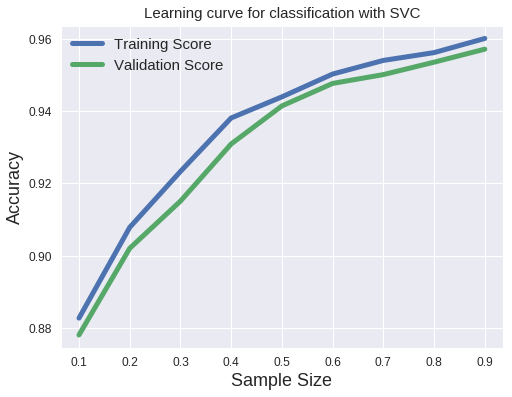

In [7]:
fig = plt.figure(figsize=(8,6))
xlabel = 'Sample Size'
ylabel = 'Accuracy'

svc_title = 'Learning curve for classification with SVC'
knn_title = 'Learning curve for classification with KNN'

ax1 = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=svc_title)

ax1.plot(ns_list, svc_scores[:,0], label = 'Training Score')
ax1.plot(ns_list, svc_scores[:,1], label = 'Validation Score')
ax1.legend(loc=0)



plt.show()

In [0]:
from sklearn.utils import shuffle
df = shuffle(m_data)

X = m_data[features]
# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)

Y = m_data['target']



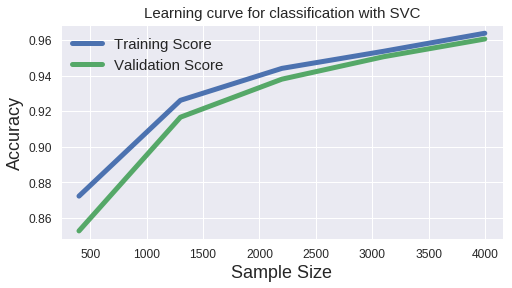

In [10]:
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator = SVC(), X = X,
                                                   y = Y,  cv = 5,
                                                   scoring = 'accuracy', random_state=11)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

xlabel = 'Sample Size'
ylabel = 'Accuracy'

svc_title = 'Learning curve for classification with SVC'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=svc_title)
ax.plot(ns_list, train_scores_mean, label = 'Training Score')
ax.plot(ns_list, validation_scores_mean, label = 'Validation Score')
# plt.yscale('log')
ax.legend(loc=0)
plt.show()

In [12]:
print('Training scores:\n\n', pd.DataFrame( train_scores) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(validation_scores) )

Training scores:

           0         1         2         3         4
0  0.887500  0.812500  0.812500  0.812500  0.812500
1  0.853846  0.834615  0.846154  0.846154  0.846154
2  0.868182  0.868182  0.872727  0.870455  0.870455
3  0.882258  0.883871  0.882258  0.885484  0.887097
4  0.882500  0.885000  0.885000  0.891250  0.892500

 ----------------------------------------------------------------------

Validation scores:

        0      1      2      3      4
0  0.735  0.810  0.800  0.825  0.775
1  0.820  0.825  0.825  0.870  0.810
2  0.860  0.860  0.855  0.890  0.830
3  0.865  0.870  0.870  0.890  0.855
4  0.875  0.895  0.880  0.910  0.860


In [0]:
from sklearn.linear_model import SGDClassifier

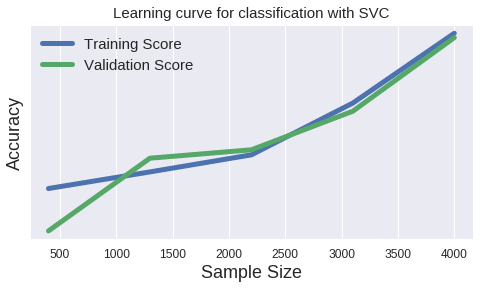

In [11]:
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator = SGDClassifier(), X = X,
                                                   y = Y,  cv = 5,
                                                   scoring = 'accuracy', random_state=11)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

xlabel = 'Sample Size'
ylabel = 'Accuracy'

svc_title = 'Learning curve for classification with SVC'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=svc_title)
ax.plot(ns_list, train_scores_mean, label = 'Training Score')
ax.plot(ns_list, validation_scores_mean, label = 'Validation Score')
plt.yscale('log')
ax.legend(loc=0)
plt.show()